Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 5_Dogs vs Cats Image Classification With Image Augmentation

In this tutorial, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using tf.keras.Sequential model and load data using tf.keras.preprocessing.image.ImageDataGenerator.

#### Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

- Building data input pipelines using the tf.keras.preprocessing.image.ImageDataGenerator class — How can we efficiently work with data on disk to interface with our model?
- Overfitting - what is it, how to identify it, and how can we prevent it?
- Data Augmentation and Dropout - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.

#### We will follow the general machine learning workflow:
1. Examine and understand data
2. Build an input pipeline
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

#### Import packages

In [1]:
import tensorflow as tf
     
from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
import os
import numpy as np
import matplotlib.pyplot as plt

#### Data Loading

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

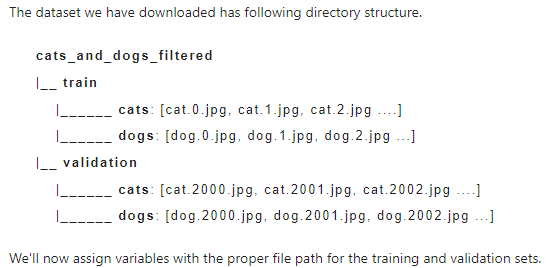

In [3]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
     
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [4]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
     

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### Setting Model Parameters
For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

In [5]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

Batch size and image shape are two crucial hyperparameters that significantly impact the performance and efficiency of image classification with Convolutional Neural Networks (CNNs). Here's a breakdown of their implications:

Batch Size:

- Training Speed:
    - Larger batch sizes allow for faster training per epoch by performing a single weight update after processing a batch of images.
    - Smaller batch sizes require more weight updates per epoch due to smaller batches, leading to slower training but potentially better convergence.
- Generalization:
    - Larger batch sizes can lead to overfitting if the model focuses too much on specific patterns within the batch and fails to generalize well to unseen data.
    - Smaller batch sizes can help mitigate overfitting by exposing the model to more diverse samples during each update, potentially improving generalization.
- Memory Usage:
    - Larger batch sizes require more memory to store the images within a batch during training. This can be a limitation for resource-constrained environments.
    - Smaller batch sizes require less memory, making them suitable for training on devices with limited memory.

Image Shape:

- Model Complexity:
    - Larger image shapes (higher resolution) can capture more details but lead to a more complex model with more parameters. Training such models requires more data and computational resources.
    - Smaller image shapes (lower resolution) result in simpler models with fewer parameters. However, they might miss crucial details in the images, impacting performance.
- Performance:
    - Larger image shapes can potentially lead to better performance if the model can effectively utilize the additional information.
    - Smaller image shapes might lead to lower performance due to the loss of detailed information, especially for complex image classification tasks.
- Preprocessing Costs:
    - Larger image shapes require more processing power for resizing and normalization during data preprocessing.
    - Smaller image shapes require less processing power for preprocessing, making them faster to train on.

Finding the Optimal Balance:

Finding the optimal batch size and image shape depends on several factors, including:

- Dataset size: Larger datasets can often handle larger batch sizes without significant overfitting.
- Model architecture: More complex models might benefit from larger image shapes to capture more details.
- Computational resources: Limited memory or processing power might necessitate smaller batch sizes and image shapes.

Here are some general recommendations:

- Batch size: Experiment with different batch sizes (e.g., 32, 64, 128) and monitor validation performance to avoid overfitting.
- Image shape: Start with commonly used image sizes like 224x224 or 299x299, which work well for many pre-trained models. Adjust based on your dataset and performance.

Additional Tips:

- Consider using techniques like learning rate scheduling and data augmentation to improve generalization and potentially handle larger batch sizes.
- Leverage techniques like transfer learning with pre-trained models to reduce training complexity, especially when dealing with limited datasets.

By understanding the implications of batch size and image shape, you can effectively tune these hyperparameters to achieve optimal performance and efficiency for your image classification tasks with CNNs.

#### Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#### Flipping the image horizontally

In [9]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

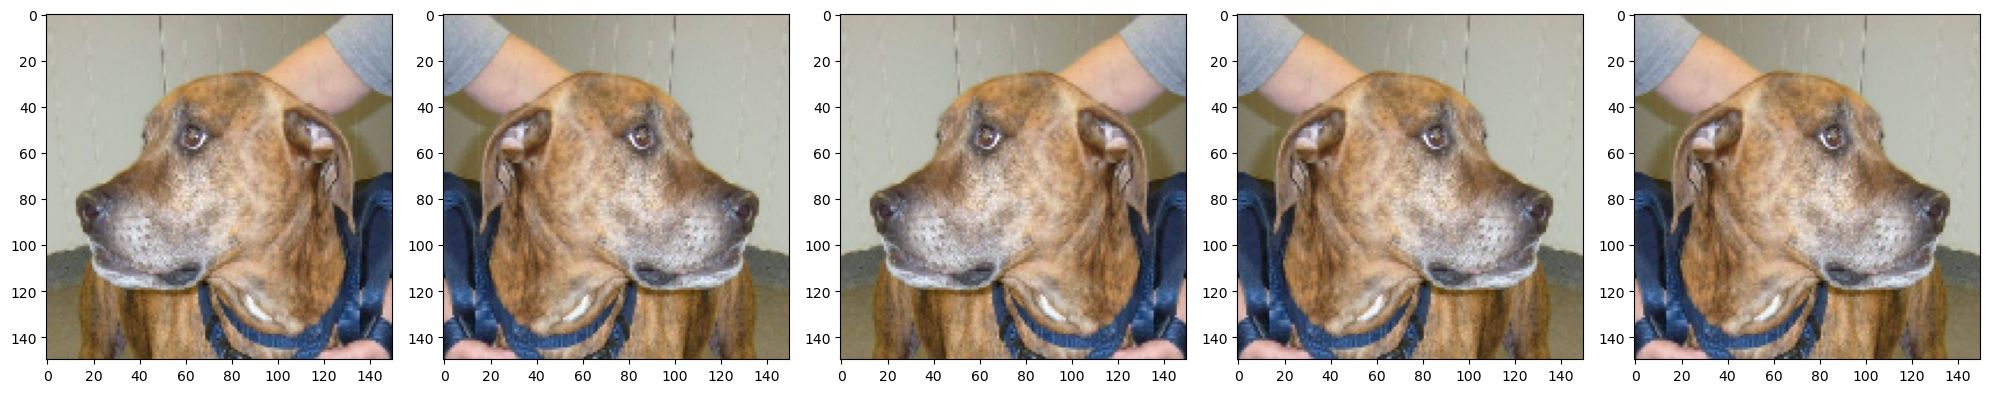

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Rotating the image
The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


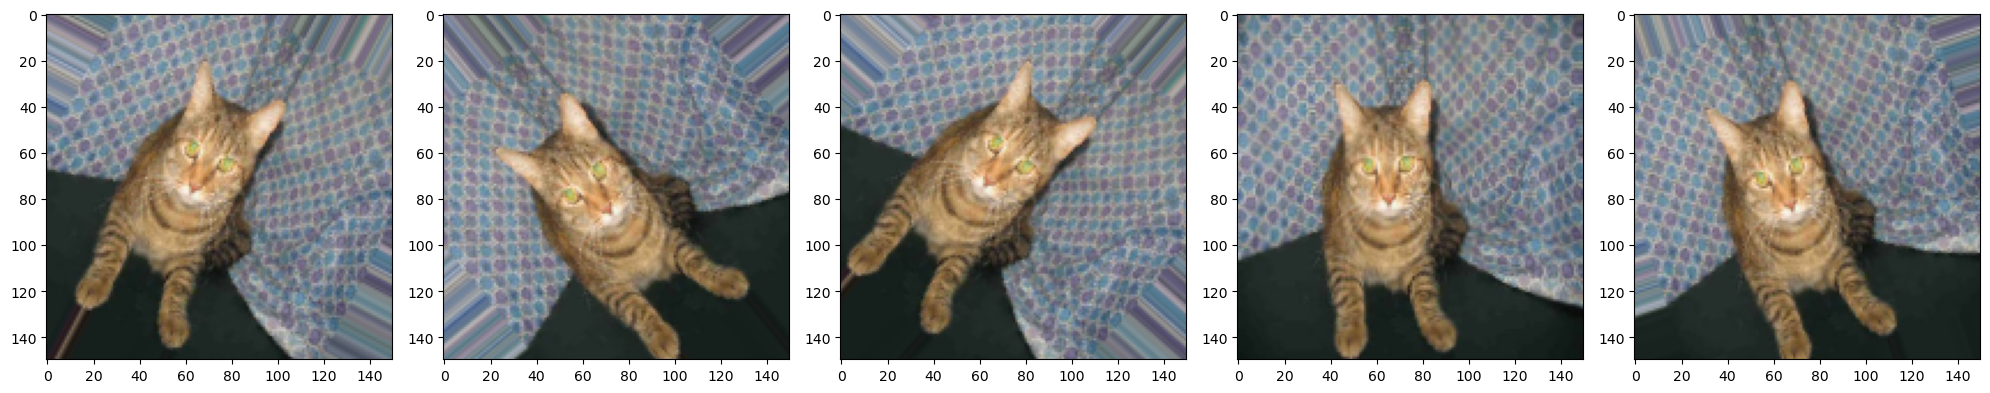

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Applying Zoom
We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

Found 2000 images belonging to 2 classes.


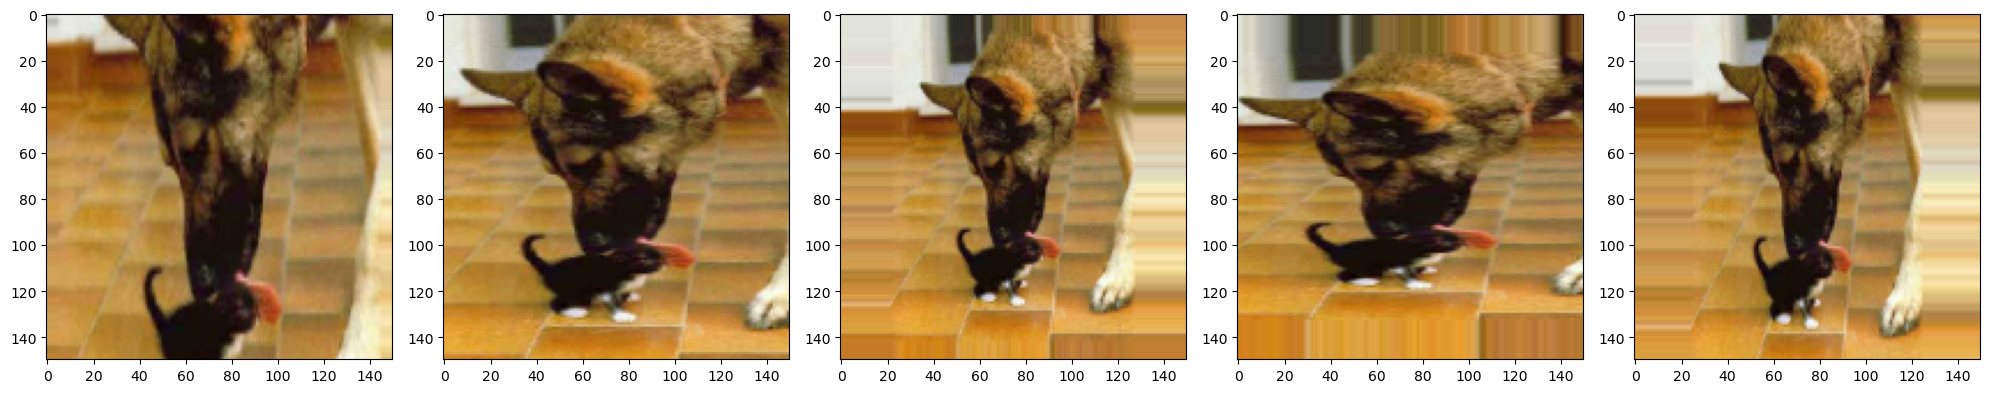

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Putting it all together
We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [16]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


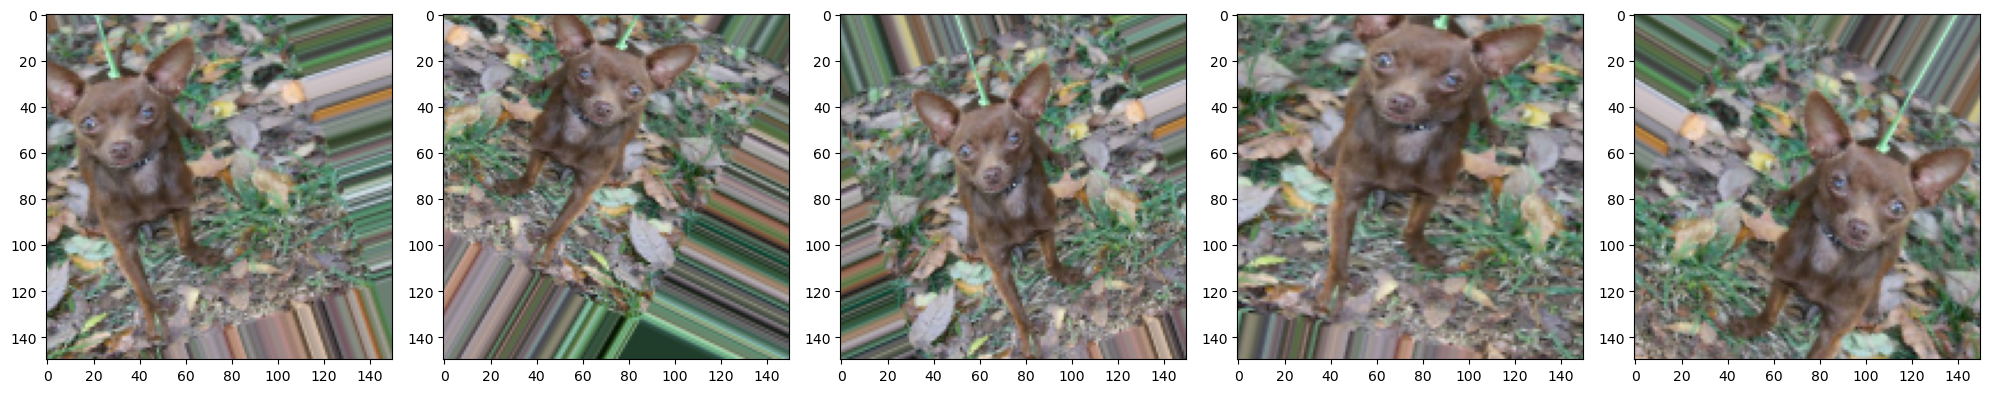

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Creating Validation Data generator
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator

In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Model Creation
##### Define the model
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Added dropout layer - regularization technique for preventing overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

##### Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

#### Train the model
It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [23]:
epochs=20
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

C:\Users\ih371\AppData\Local\Temp\ipykernel_26136\711703578.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20



c:\Users\ih371\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



20/20 [==============================] - 21s 969ms/step - loss: 0.7179 - accuracy: 0.4980 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 12s 595ms/step - loss: 0.6908 - accuracy: 0.5345 - val_loss: 0.6859 - val_accuracy: 0.6210
Epoch 3/20
20/20 [==============================] - 12s 597ms/step - loss: 0.6773 - accuracy: 0.5730 - val_loss: 0.6400 - val_accuracy: 0.6530
Epoch 4/20
20/20 [==============================] - 12s 600ms/step - loss: 0.6746 - accuracy: 0.5765 - val_loss: 0.6803 - val_accuracy: 0.5290
Epoch 5/20
20/20 [==============================] - 12s 595ms/step - loss: 0.6784 - accuracy: 0.5760 - val_loss: 0.6646 - val_accuracy: 0.5580
Epoch 6/20
20/20 [==============================] - 12s 607ms/step - loss: 0.6477 - accuracy: 0.6310 - val_loss: 0.6176 - val_accuracy: 0.6560
Epoch 7/20
20/20 [==============================] - 12s 609ms/step - loss: 0.6368 - accuracy: 0.6445 - val_loss: 0.6045 - val_accuracy: 0.6520
Epoch 8/2

#### Visualizing results of the training
We'll now visualize the results we get after training our network.

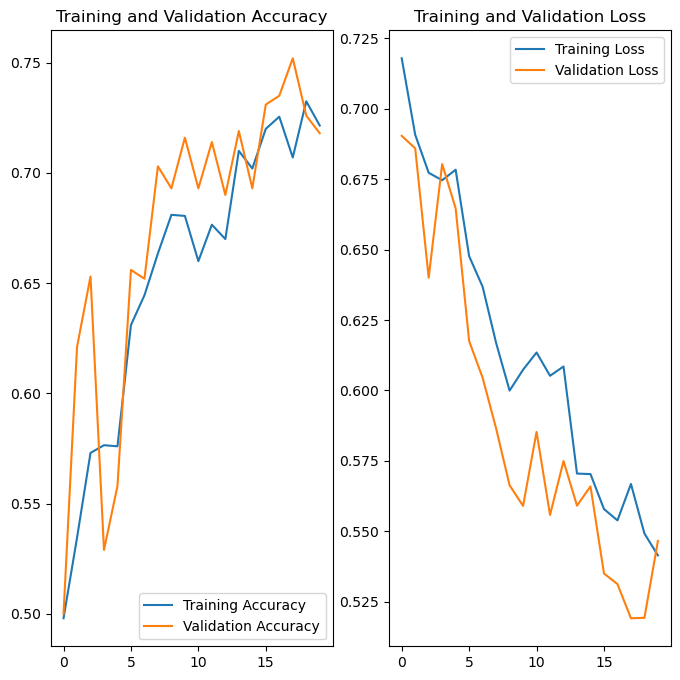

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 87ms/step


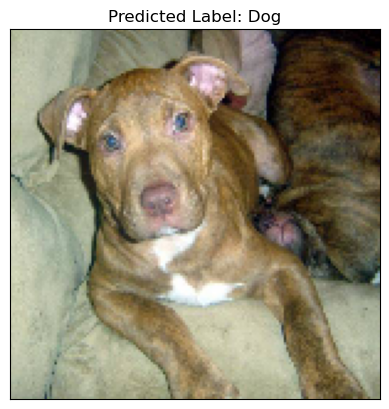

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch of data
data, labels = next(val_data_gen)

first_image = data[0]  # Assuming the first image in the batch

# Make prediction on the first image
predictions = model.predict(np.expand_dims(first_image, axis=0))

# Decode the label
class_names = ['Cat','Dog']  # Replace with your class names
predicted_class = np.argmax(predictions[0])  # Index of the maximum value
predicted_label_text = class_names[predicted_class]

# Rescale the image data to a range of 0-1 for visualization
if np.max(first_image) > 1:
  first_image = first_image / 255.0  # Assuming image data is in range 0-255

# Plot the image
plt.imshow(first_image)
plt.title("Predicted Label: " + predicted_label_text)
plt.xticks([])
plt.yticks([])
plt.show()

1/1 [==============================] - 0s 16ms/step
[0.74613065 0.25386932]
1/1 [==============================] - 0s 15ms/step
[0.81770253 0.1822975 ]
1/1 [==============================] - 0s 15ms/step
[0.6162413  0.38375866]
1/1 [==============================] - 0s 16ms/step
[0.5737997  0.42620024]
1/1 [==============================] - 0s 16ms/step
[0.87028867 0.12971136]
1/1 [==============================] - 0s 15ms/step
[0.4544837 0.5455164]
1/1 [==============================] - 0s 17ms/step
[0.39159176 0.6084083 ]
1/1 [==============================] - 0s 16ms/step
[0.7973885  0.20261154]
1/1 [==============================] - 0s 17ms/step
[0.15074484 0.84925514]
1/1 [==============================] - 0s 17ms/step
[0.28406575 0.71593434]


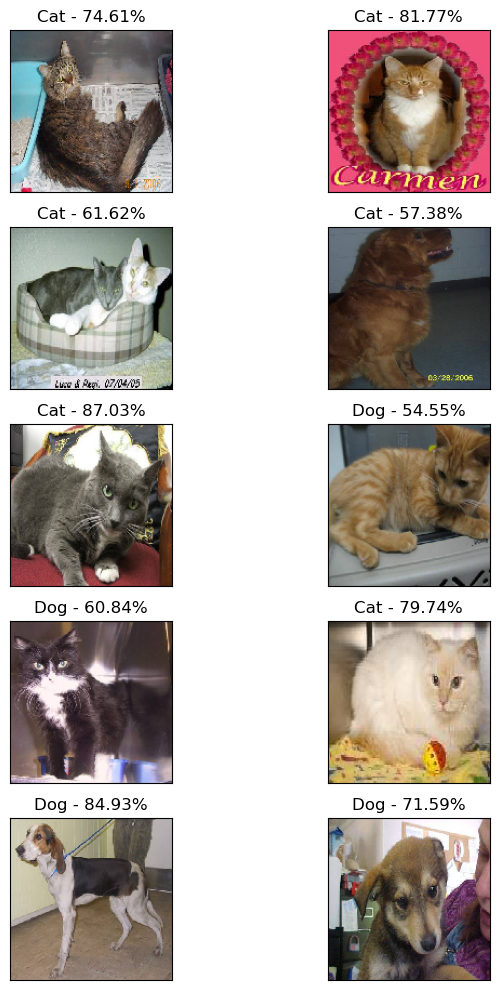

In [26]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(8, 10))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['Cat', 'Dog']
  predicted_class = np.argmax(predictions[0])
  predicted_label_text = class_names[predicted_class]
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text} - {confidence:.2f}%")  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()

#### Experiment with binary cross entropy

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Added dropout layer - regularization technique for preventing overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

We utilize sigmoid activation for the output layer with 1 neuron output as we expect a binary 0 or 1 classification output. We also use binary_crossentropy instead of categorical crossentropy too.

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [32]:
epochs=20
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

C:\Users\ih371\AppData\Local\Temp\ipykernel_26136\711703578.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
20/20 [==============================] - 14s 620ms/step - loss: 0.7101 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 12s 603ms/step - loss: 0.6924 - accuracy: 0.5005 - val_loss: 0.6870 - val_accuracy: 0.6120
Epoch 3/20
20/20 [==============================] - 12s 600ms/step - loss: 0.6870 - accuracy: 0.5460 - val_loss: 0.6644 - val_accuracy: 0.6350
Epoch 4/20
20/20 [==============================] - 12s 601ms/step - loss: 0.6763 - accuracy: 0.5785 - val_loss: 0.6804 - val_accuracy: 0.5140
Epoch 5/20
20/20 [==============================] - 12s 605ms/step - loss: 0.6608 - accuracy: 0.5990 - val_loss: 0.6470 - val_accuracy: 0.5620
Epoch 6/20
20/20 [==============================] - 12s 618ms/step - loss: 0.6666 - accuracy: 0.5775 - val_loss: 0.6685 - val_accuracy: 0.5450
Epoch 7/20
20/20 [==============================] - 12s 611ms/step - loss: 0.6521 - accuracy: 0.6050 - val_loss: 0.6451 - val_accuracy: 0.6240

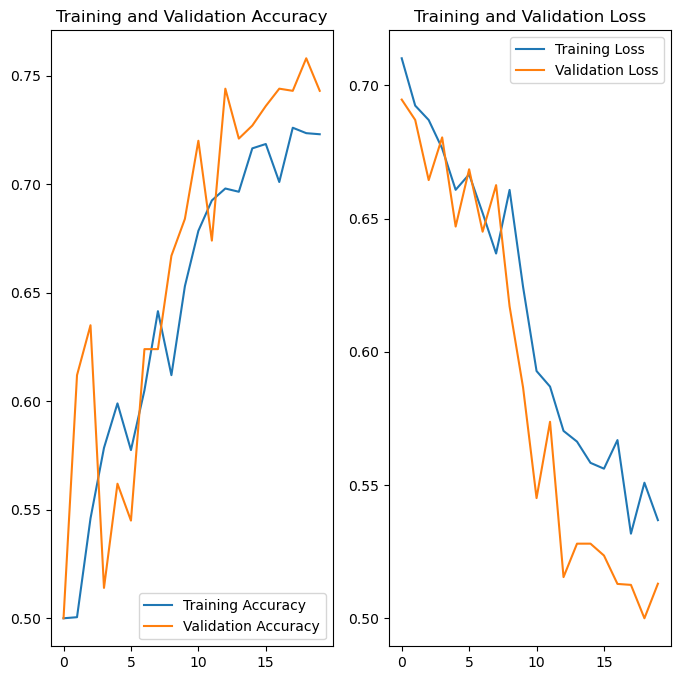

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 15ms/step
[0.4306955]
1/1 [==============================] - 0s 16ms/step
[0.50929]
1/1 [==============================] - 0s 15ms/step
[0.63221604]
1/1 [==============================] - 0s 15ms/step
[0.68208516]
1/1 [==============================] - 0s 15ms/step
[0.56894857]
1/1 [==============================] - 0s 16ms/step
[0.1606005]
1/1 [==============================] - 0s 16ms/step
[0.47701216]
1/1 [==============================] - 0s 16ms/step
[0.21729663]
1/1 [==============================] - 0s 17ms/step
[0.15124822]
1/1 [==============================] - 0s 15ms/step
[0.24770872]


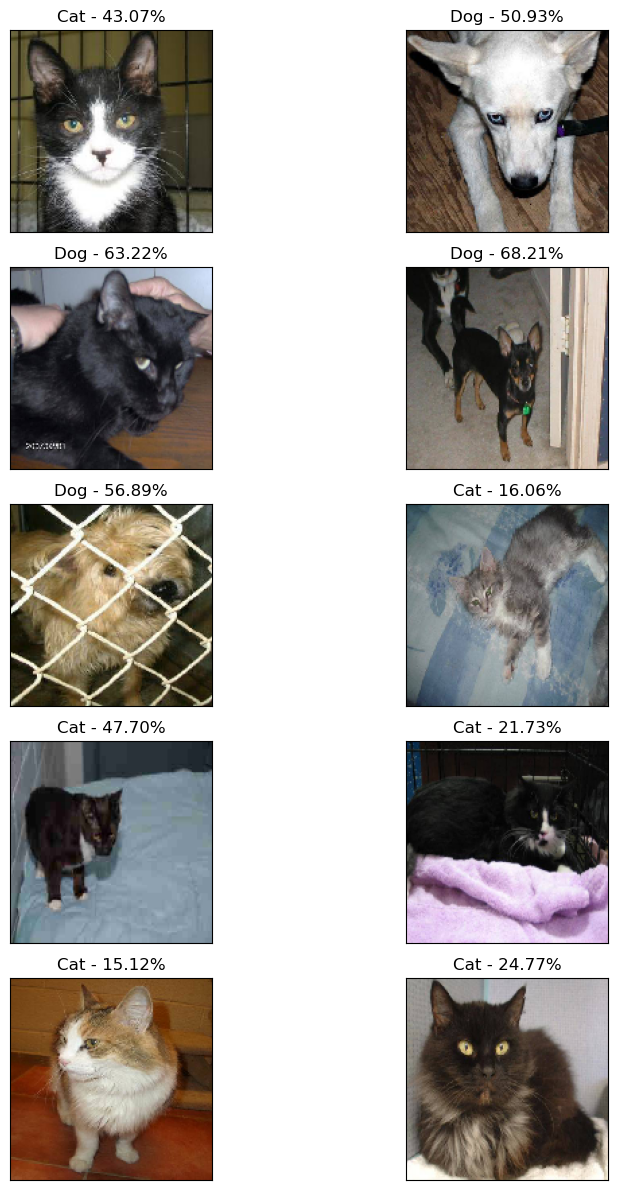

: 

In [39]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(10, 12))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['Cat', 'Dog']
  predicted_class = [0 if np.max(predictions[0]) < 0.5 else 1] #Threshold set to 0.5 / 50%
  predicted_label_text = class_names[predicted_class[0]]
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text} - {confidence:.2f}%")  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()